# Analyze PM2.5 and PM10 data

In [1]:
import geopandas as gpd
import geoplot
import numpy as np
import pandas as pd
import calendar

import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import mlab as ml
from matplotlib import gridspec


import seaborn as sns

plt.ion() # turn on interactive plotting
plt.rcParams['figure.figsize'] = [20, 15] # enlarge the default plotting size

from sklearn.neighbors import KernelDensity

from mpl_toolkits.basemap import Basemap


table_path="I:/Thailand_Haze/tables/"
fire_path="I:/Thailand_Haze/fire_data/"
gis_path="I:/Thailand_Haze/GIS_data/"

## Read and process data

Read the excel file

In [2]:
PM10_36T = pd.read_excel(table_path+'PM.xlsx', sheet_name='36T_PM10').replace(-99, np.nan)
PM10_35T = pd.read_excel(table_path+'PM.xlsx', sheet_name='35T_PM10').replace(-99, np.nan)
PM25_36T = pd.read_excel(table_path+'PM.xlsx', sheet_name='36T_PM2.5').replace(-99, np.nan)
PM25_35T = pd.read_excel(table_path+'PM.xlsx', sheet_name='35T_PM2.5').replace(-99, np.nan)

Convert the table from wide to long (melt)

In [3]:
PM10_36T = pd.melt(PM10_36T, id_vars=['Month', 'Day'], value_vars=list(range(1995, 2020,1))).rename(columns={"variable": "year"})
PM10_35T = pd.melt(PM10_35T, id_vars=['Month', 'Day'], value_vars=list(range(1995, 2020,1))).rename(columns={"variable": "year"})
PM25_36T = pd.melt(PM25_36T, id_vars=['Month', 'Day'], value_vars=list(range(2004, 2020,1))).rename(columns={"variable": "year"})
PM25_35T = pd.melt(PM25_35T, id_vars=['Month', 'Day'], value_vars=list(range(2016, 2020,1))).rename(columns={"variable": "year"})

Create datetime field

In [4]:
non_leap_years = ['2-29-1995','2-29-1997','2-29-1998','2-29-1999','2-29-2001','2-29-2002','2-29-2003','2-29-2005','2-29-2006','2-29-2007','2-29-2009','2-29-2010','2-29-2011','2-29-2012','2-29-2013','2-29-2014','2-29-2015','2-29-2017','2-29-2018','2-29-2019']
PM10_36T['date_time'] = PM10_36T['Month'].astype(str) +"-"+ PM10_36T['Day'].astype(str)  +"-"+ PM10_36T['year'].astype(str) 
PM10_35T['date_time'] = PM10_35T['Month'].astype(str) +"-"+ PM10_35T['Day'].astype(str)  +"-"+ PM10_35T['year'].astype(str)
PM25_36T['date_time'] = PM25_36T['Month'].astype(str) +"-"+ PM25_36T['Day'].astype(str)  +"-"+ PM25_36T['year'].astype(str) 
PM25_35T['date_time'] = PM25_35T['Month'].astype(str) +"-"+ PM25_35T['Day'].astype(str)  +"-"+ PM25_35T['year'].astype(str) 

PM10_36T = PM10_36T[~PM10_36T['date_time'].isin(non_leap_years)]
PM10_35T = PM10_35T[~PM10_35T['date_time'].isin(non_leap_years)]
PM25_36T = PM25_36T[~PM25_36T['date_time'].isin(non_leap_years)]
PM25_35T = PM25_35T[~PM25_35T['date_time'].isin(non_leap_years)]

PM10_36T['date_time']= pd.to_datetime(PM10_36T['date_time'])
PM10_35T['date_time']= pd.to_datetime(PM10_35T['date_time'])
PM25_36T['date_time']= pd.to_datetime(PM25_36T['date_time'])
PM25_35T['date_time']= pd.to_datetime(PM25_35T['date_time'])


### Thresholds for polluted days: 
- PM2.5: 
    - Thailand standard: absolute concentration > 50 for 24 h average 
    - US standard: absolute concentration > 25 for 24 h average
- PM10:
    - Thailand standard: absolute concentration > 120 for 24 h average 
    - US standard: absolute concentration > 50 for 24 h average 

### Plot total polluted days by year

Select days above the thresholds

In [5]:
# Thailand standard
PM10_36T_pl_th = PM10_36T[PM10_36T['value']>120]
PM10_35T_pl_th = PM10_35T[PM10_35T['value']>120]

PM25_36T_pl_th = PM25_36T[PM25_36T['value']>50]
PM25_35T_pl_th = PM25_35T[PM25_35T['value']>50]

# US standard
PM10_36T_pl_us = PM10_36T[PM10_36T['value']>50]
PM10_35T_pl_us = PM10_35T[PM10_35T['value']>50]

PM25_36T_pl_us = PM25_36T[PM25_36T['value']>25]
PM25_35T_pl_us = PM25_35T[PM25_35T['value']>25]

# All days with data
PM10_36T_all = PM10_36T[~np.isnan(PM10_36T['value'])]
PM10_35T_all = PM10_35T[~np.isnan(PM10_35T['value'])]
PM25_36T_all = PM25_36T[~np.isnan(PM25_36T['value'])]
PM25_35T_all = PM25_35T[~np.isnan(PM25_35T['value'])]

Organize the counts of polluted days (> thresholds) in a dataframe

In [7]:
# Plot PM 10 bar chart
#x_pos_35T=np.arange(len(year_ls_pm10))
#x_pos_36T=np.arange(len(year_ls_pm10)) + w

# Count pollutated days regarding PM10
PM10_36T_pl_th_y = PM10_36T_pl_th.groupby(PM10_36T_pl_th['date_time'].dt.year)['date_time'].count()
PM10_35T_pl_th_y = PM10_35T_pl_th.groupby(PM10_35T_pl_th['date_time'].dt.year)['date_time'].count()
PM10_36T_pl_us_y = PM10_36T_pl_us.groupby(PM10_36T_pl_us['date_time'].dt.year)['date_time'].count()
PM10_35T_pl_us_y = PM10_35T_pl_us.groupby(PM10_35T_pl_us['date_time'].dt.year)['date_time'].count()

# Count pollutated days regarding PM2.5
PM25_36T_pl_th_y = PM25_36T_pl_th.groupby(PM25_36T_pl_th['date_time'].dt.year)['date_time'].count()
PM25_35T_pl_th_y = PM25_35T_pl_th.groupby(PM25_35T_pl_th['date_time'].dt.year)['date_time'].count()
PM25_36T_pl_us_y = PM25_36T_pl_us.groupby(PM25_36T_pl_us['date_time'].dt.year)['date_time'].count()
PM25_35T_pl_us_y = PM25_35T_pl_us.groupby(PM25_35T_pl_us['date_time'].dt.year)['date_time'].count()

# Count days with data
PM10_36T_all_y = PM10_36T_all.groupby(PM10_36T_all['date_time'].dt.year)['date_time'].count()
PM10_35T_all_y = PM10_35T_all.groupby(PM10_35T_all['date_time'].dt.year)['date_time'].count()
PM25_36T_all_y = PM25_36T_all.groupby(PM25_36T_all['date_time'].dt.year)['date_time'].count()
PM25_35T_all_y = PM25_35T_all.groupby(PM25_35T_all['date_time'].dt.year)['date_time'].count()

PM_df = pd.concat([PM10_36T_pl_th_y,PM10_35T_pl_th_y,PM10_36T_pl_us_y,PM10_35T_pl_us_y,PM25_36T_pl_th_y,PM25_35T_pl_th_y,PM25_36T_pl_us_y,PM25_35T_pl_us_y,PM10_36T_all_y,PM10_35T_all_y,PM25_36T_all_y,PM25_35T_all_y], axis=1)
PM_df.columns=["PM10_36T_th","PM10_35T_th","PM10_36T_us","PM10_35T_us","PM25_36T_th","PM25_35T_th","PM25_36T_us","PM25_35T_us","PM10_36T_all","PM10_35T_all","PM25_36T_all","PM25_35T_all"]
PM_df = PM_df.reset_index().rename(columns={'date_time':'year'})

PM_df['PM10_36T_th_R']=PM_df['PM10_36T_th']/PM_df['PM10_36T_all']
PM_df['PM10_35T_th_R']=PM_df['PM10_35T_th']/PM_df['PM10_35T_all']
PM_df['PM10_36T_us_R']=PM_df['PM10_36T_us']/PM_df['PM10_36T_all']
PM_df['PM10_35T_us_R']=PM_df['PM10_35T_us']/PM_df['PM10_35T_all']

PM_df['PM25_36T_th_R']=PM_df['PM25_36T_th']/PM_df['PM25_36T_all']
PM_df['PM25_35T_th_R']=PM_df['PM25_35T_th']/PM_df['PM25_35T_all']
PM_df['PM25_36T_us_R']=PM_df['PM25_36T_us']/PM_df['PM25_36T_all']
PM_df['PM25_35T_us_R']=PM_df['PM25_35T_us']/PM_df['PM25_35T_all']

# Analysis by Year

### Total pollutated days per year (PM10)

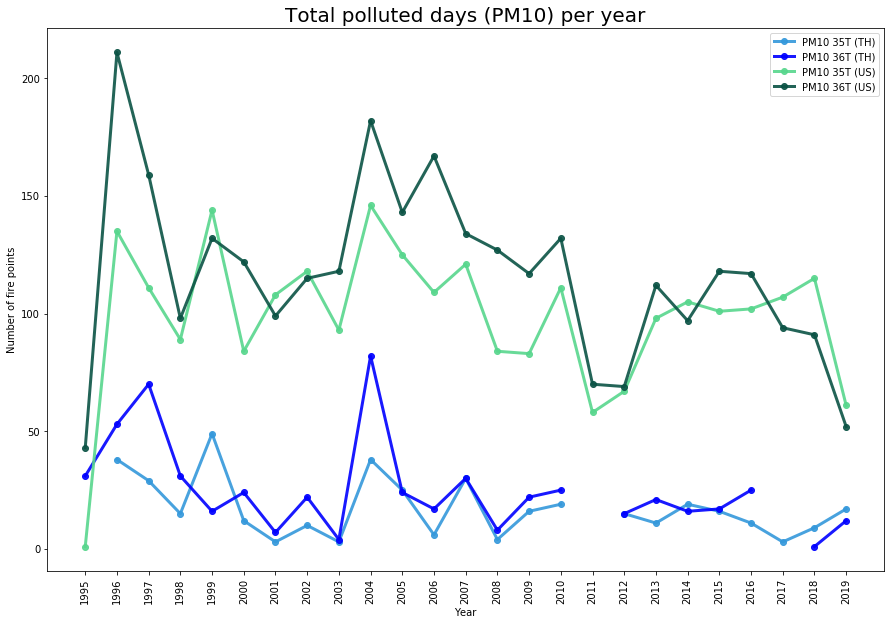

In [8]:
year_ls = list(PM_df['year'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(year_ls, PM_df['PM10_35T_th'], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM10 35T (TH)')
plt.plot(year_ls, PM_df['PM10_36T_th'], marker="o", color='b', linewidth=3, alpha=0.9, label='PM10 36T (TH)')
plt.plot(year_ls, PM_df['PM10_35T_us'], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM10 35T (US)')
plt.plot(year_ls, PM_df['PM10_36T_us'], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM10 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(year_ls, year_ls,rotation=90)
plt.ylabel('Number of fire points')
plt.xlabel('Year')
plt.title('Total polluted days (PM10) per year', loc='Center', fontsize=20, fontweight=0)

plt.show()

### Ratio of pollutated days per year (PM10)

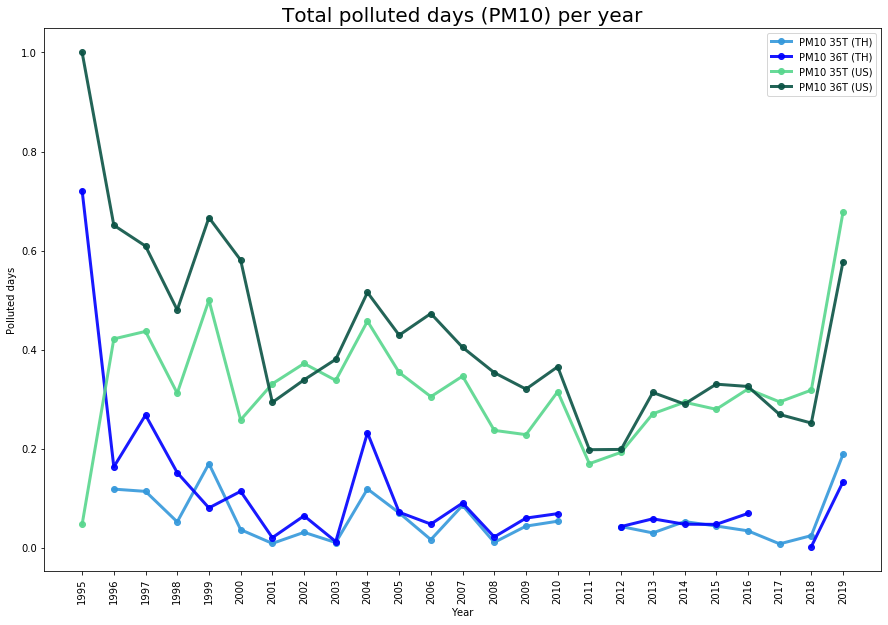

In [9]:
year_ls = list(PM_df['year'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(year_ls, PM_df['PM10_35T_th_R'], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM10 35T (TH)')
plt.plot(year_ls, PM_df['PM10_36T_th_R'], marker="o", color='b', linewidth=3, alpha=0.9, label='PM10 36T (TH)')
plt.plot(year_ls, PM_df['PM10_35T_us_R'], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM10 35T (US)')
plt.plot(year_ls, PM_df['PM10_36T_us_R'], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM10 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(year_ls, year_ls,rotation=90)
plt.ylabel('Polluted days')
plt.xlabel('Year')
plt.title('Total polluted days (PM10) per year', loc='Center', fontsize=20, fontweight=0)

plt.show()

### Total pollutated days per year (PM2.5)

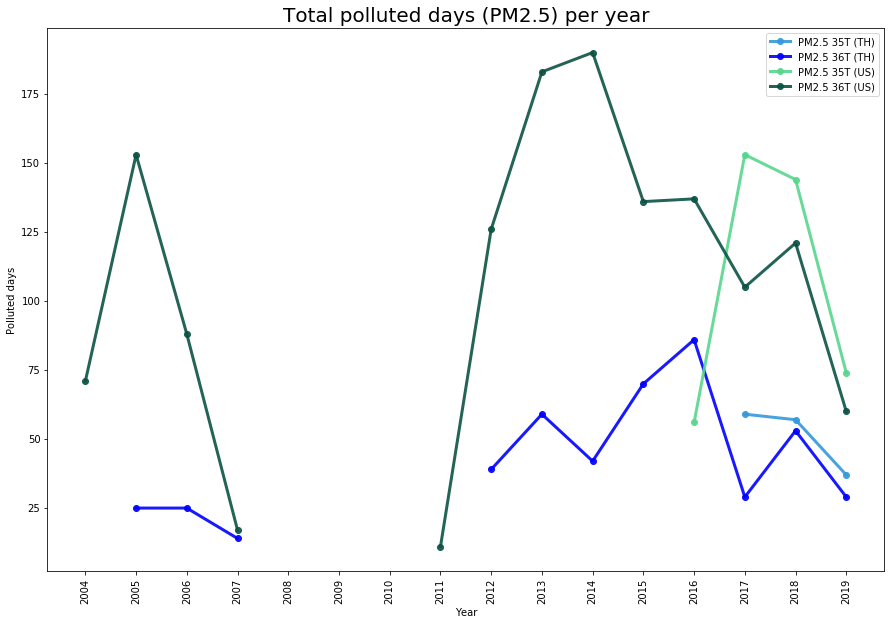

In [10]:
color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(year_ls[9:], PM_df['PM25_35T_th'][9:], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM2.5 35T (TH)')
plt.plot(year_ls[9:], PM_df['PM25_36T_th'][9:], marker="o", color='b', linewidth=3, alpha=0.9, label='PM2.5 36T (TH)')
plt.plot(year_ls[9:], PM_df['PM25_35T_us'][9:], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM2.5 35T (US)')
plt.plot(year_ls[9:], PM_df['PM25_36T_us'][9:], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM2.5 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(year_ls[9:], year_ls[9:],rotation=90)
plt.ylabel('Polluted days')
plt.xlabel('Year')
plt.title('Total polluted days (PM2.5) per year', loc='Center', fontsize=20, fontweight=0)

plt.show()

### Ratio of pollutated days per year (PM2.5)

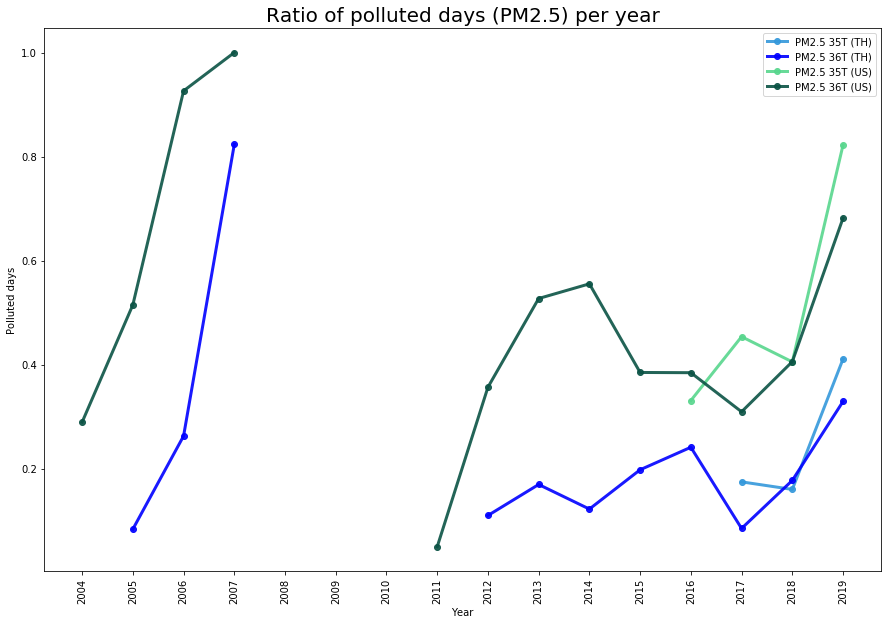

In [11]:
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(year_ls[9:], PM_df['PM25_35T_th_R'][9:], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM2.5 35T (TH)')
plt.plot(year_ls[9:], PM_df['PM25_36T_th_R'][9:], marker="o", color='b', linewidth=3, alpha=0.9, label='PM2.5 36T (TH)')
plt.plot(year_ls[9:], PM_df['PM25_35T_us_R'][9:], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM2.5 35T (US)')
plt.plot(year_ls[9:], PM_df['PM25_36T_us_R'][9:], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM2.5 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(year_ls[9:], year_ls[9:],rotation=90)
plt.ylabel('Polluted days')
plt.xlabel('Year')
plt.title('Ratio of polluted days (PM2.5) per year', loc='Center', fontsize=20, fontweight=0)

plt.show()

# Montly Analysis

In [13]:
# Plot PM 10 bar chart
#x_pos_35T=np.arange(len(year_ls_pm10))
#x_pos_36T=np.arange(len(year_ls_pm10)) + w

# Count pollutated days regarding PM10
PM10_36T_pl_th_m = PM10_36T_pl_th.groupby(PM10_36T_pl_th['date_time'].dt.month)['date_time'].count()
PM10_35T_pl_th_m = PM10_35T_pl_th.groupby(PM10_35T_pl_th['date_time'].dt.month)['date_time'].count()
PM10_36T_pl_us_m = PM10_36T_pl_us.groupby(PM10_36T_pl_us['date_time'].dt.month)['date_time'].count()
PM10_35T_pl_us_m = PM10_35T_pl_us.groupby(PM10_35T_pl_us['date_time'].dt.month)['date_time'].count()

# Count pollutated days regarding PM2.5
PM25_36T_pl_th_m = PM25_36T_pl_th.groupby(PM25_36T_pl_th['date_time'].dt.month)['date_time'].count()
PM25_35T_pl_th_m = PM25_35T_pl_th.groupby(PM25_35T_pl_th['date_time'].dt.month)['date_time'].count()
PM25_36T_pl_us_m = PM25_36T_pl_us.groupby(PM25_36T_pl_us['date_time'].dt.month)['date_time'].count()
PM25_35T_pl_us_m = PM25_35T_pl_us.groupby(PM25_35T_pl_us['date_time'].dt.month)['date_time'].count()

# Count days with data
PM10_36T_all_m = PM10_36T_all.groupby(PM10_36T_all['date_time'].dt.month)['date_time'].count()
PM10_35T_all_m = PM10_35T_all.groupby(PM10_35T_all['date_time'].dt.month)['date_time'].count()
PM25_36T_all_m = PM25_36T_all.groupby(PM25_36T_all['date_time'].dt.month)['date_time'].count()
PM25_35T_all_m = PM25_35T_all.groupby(PM25_35T_all['date_time'].dt.month)['date_time'].count()

PM_df_m = pd.concat([PM10_36T_pl_th_m,PM10_35T_pl_th_m,PM10_36T_pl_us_m,PM10_35T_pl_us_m,PM25_36T_pl_th_m,PM25_35T_pl_th_m,PM25_36T_pl_us_m,PM25_35T_pl_us_m,PM10_36T_all_m,PM10_35T_all_m,PM25_36T_all_m,PM25_35T_all_m], axis=1)
PM_df_m.columns=["PM10_36T_th","PM10_35T_th","PM10_36T_us","PM10_35T_us","PM25_36T_th","PM25_35T_th","PM25_36T_us","PM25_35T_us","PM10_36T_all","PM10_35T_all","PM25_36T_all","PM25_35T_all"]
PM_df_m = PM_df_m.reset_index().rename(columns={'date_time':'month'})

PM_df_m['PM10_36T_th_R']=PM_df_m['PM10_36T_th']/PM_df_m['PM10_36T_all']
PM_df_m['PM10_35T_th_R']=PM_df_m['PM10_35T_th']/PM_df_m['PM10_35T_all']
PM_df_m['PM10_36T_us_R']=PM_df_m['PM10_36T_us']/PM_df_m['PM10_36T_all']
PM_df_m['PM10_35T_us_R']=PM_df_m['PM10_35T_us']/PM_df_m['PM10_35T_all']

PM_df_m['PM25_36T_th_R']=PM_df_m['PM25_36T_th']/PM_df_m['PM25_36T_all']
PM_df_m['PM25_35T_th_R']=PM_df_m['PM25_35T_th']/PM_df_m['PM25_35T_all']
PM_df_m['PM25_36T_us_R']=PM_df_m['PM25_36T_us']/PM_df_m['PM25_36T_all']
PM_df_m['PM25_35T_us_R']=PM_df_m['PM25_35T_us']/PM_df_m['PM25_35T_all']

### Total pollutated days per month (PM10)

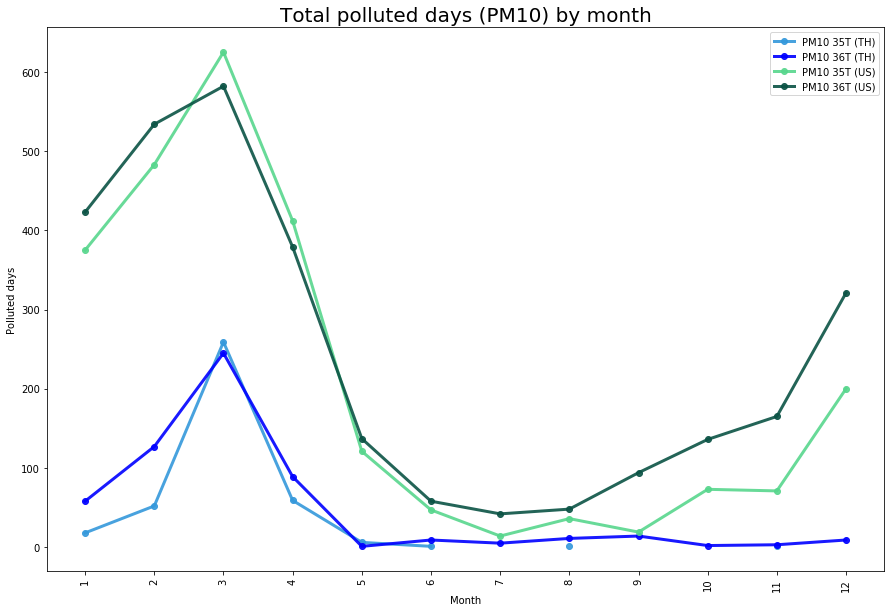

In [14]:
month_ls_m = list(PM_df_m['month'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(month_ls_m, PM_df_m['PM10_35T_th'], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM10 35T (TH)')
plt.plot(month_ls_m, PM_df_m['PM10_36T_th'], marker="o", color='b', linewidth=3, alpha=0.9, label='PM10 36T (TH)')
plt.plot(month_ls_m, PM_df_m['PM10_35T_us'], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM10 35T (US)')
plt.plot(month_ls_m, PM_df_m['PM10_36T_us'], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM10 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(month_ls_m, month_ls_m,rotation=90)
plt.ylabel('Polluted days')
plt.xlabel('Month')
plt.title('Total polluted days (PM10) by month', loc='Center', fontsize=20, fontweight=0)

plt.show()

### Total pollutated days per month (PM2.5)

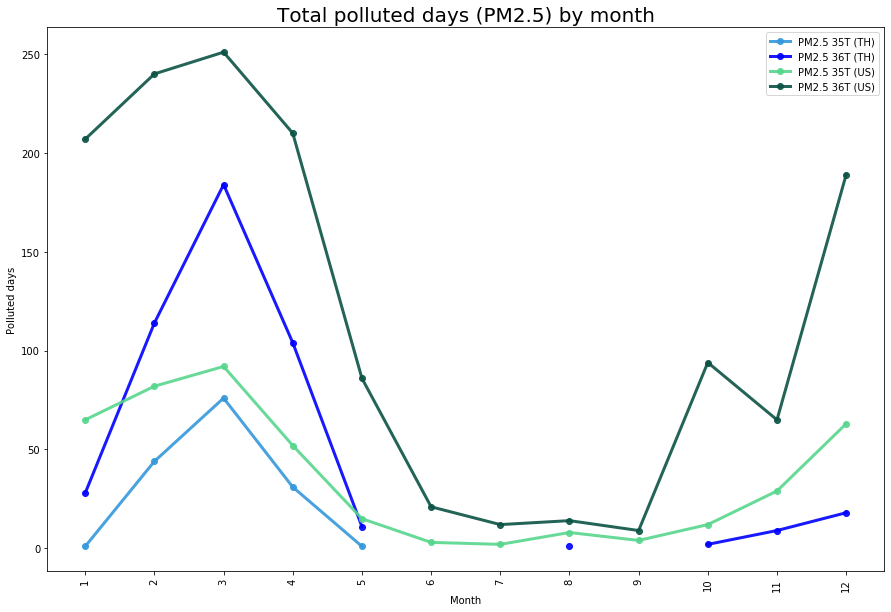

In [15]:
month_ls_m = list(PM_df_m['month'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(month_ls_m, PM_df_m['PM25_35T_th'], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM2.5 35T (TH)')
plt.plot(month_ls_m, PM_df_m['PM25_36T_th'], marker="o", color='b', linewidth=3, alpha=0.9, label='PM2.5 36T (TH)')
plt.plot(month_ls_m, PM_df_m['PM25_35T_us'], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM2.5 35T (US)')
plt.plot(month_ls_m, PM_df_m['PM25_36T_us'], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM2.5 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(month_ls_m, month_ls_m,rotation=90)
plt.ylabel('Polluted days')
plt.xlabel('Month')
plt.title('Total polluted days (PM2.5) by month', loc='Center', fontsize=20, fontweight=0)

plt.show()

### Ratio of pollutated days per month (PM10)

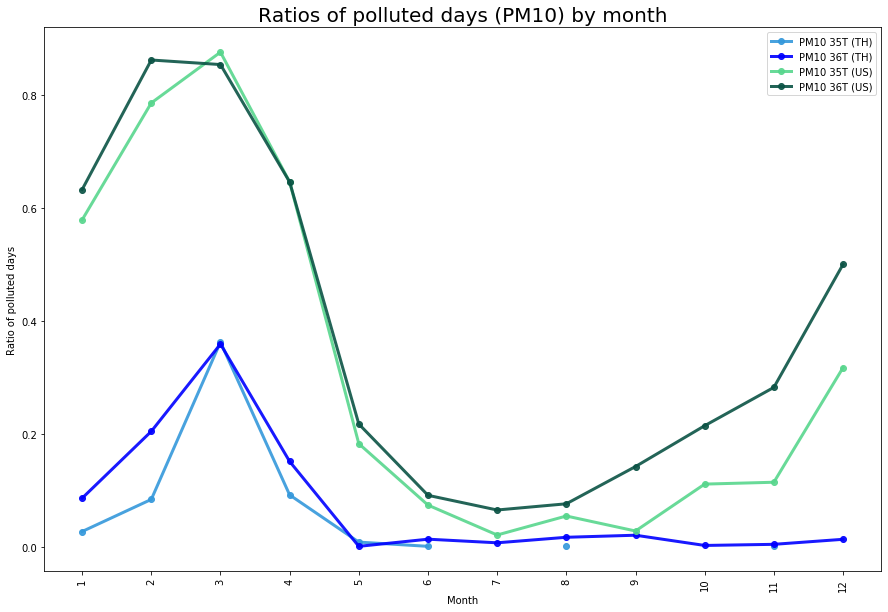

In [16]:
month_ls_m = list(PM_df_m['month'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(month_ls_m, PM_df_m['PM10_35T_th_R'], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM10 35T (TH)')
plt.plot(month_ls_m, PM_df_m['PM10_36T_th_R'], marker="o", color='b', linewidth=3, alpha=0.9, label='PM10 36T (TH)')
plt.plot(month_ls_m, PM_df_m['PM10_35T_us_R'], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM10 35T (US)')
plt.plot(month_ls_m, PM_df_m['PM10_36T_us_R'], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM10 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(month_ls_m, month_ls_m,rotation=90)
plt.ylabel('Ratio of polluted days')
plt.xlabel('Month')
plt.title('Ratios of polluted days (PM10) by month', loc='Center', fontsize=20, fontweight=0)

plt.show()

### Ratio of pollutated days per month (PM2.5)

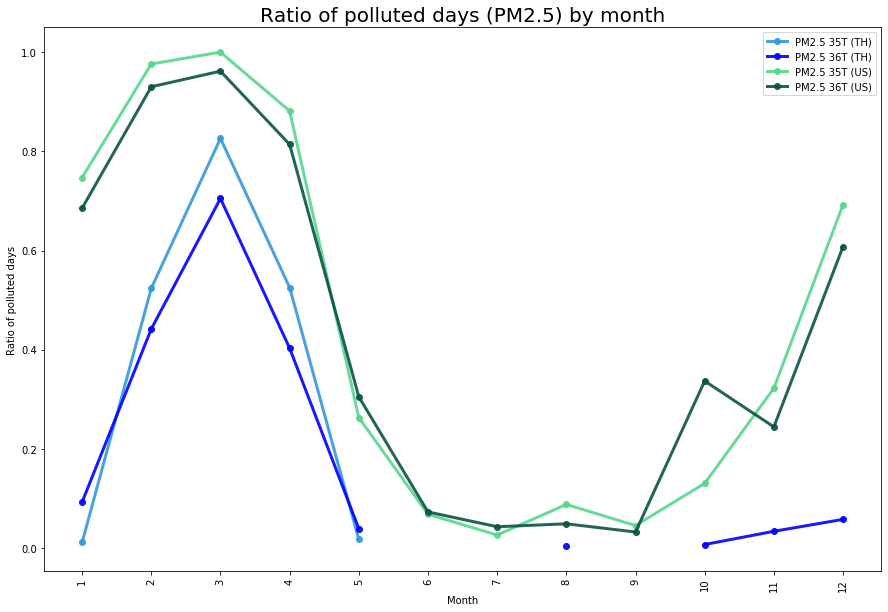

In [17]:
month_ls_m = list(PM_df_m['month'])
#color_ls = ['grey']*len(year_ls)
#color_ls[10]='red'

plt.rcParams['figure.figsize'] = [15, 10] # enlarge the default plotting size
#plt.bar(x_pos_35T, PM10_35T_pl_th, color='r', align='center', alpha=0.5,width=w)
#plt.bar(x_pos_36T, PM10_36T_pl_th, color='b', align='center', alpha=0.5,width=w)

plt.plot(month_ls_m, PM_df_m['PM25_35T_th_R'], marker="o", color='#3498DB', linewidth=3, alpha=0.9, label='PM2.5 35T (TH)')
plt.plot(month_ls_m, PM_df_m['PM25_36T_th_R'], marker="o", color='b', linewidth=3, alpha=0.9, label='PM2.5 36T (TH)')
plt.plot(month_ls_m, PM_df_m['PM25_35T_us_R'], marker="o", color='#58D68D', linewidth=3, alpha=0.9, label='PM2.5 35T (US)')
plt.plot(month_ls_m, PM_df_m['PM25_36T_us_R'], marker="o", color='#0B5345', linewidth=3, alpha=0.9, label='PM2.5 36T (US)')

# Add legend
plt.legend(loc='upper right')

plt.xticks(month_ls_m, month_ls_m,rotation=90)
plt.ylabel('Ratio of polluted days')
plt.xlabel('Month')
plt.title('Ratio of polluted days (PM2.5) by month', loc='Center', fontsize=20, fontweight=0)

plt.show()

## Change of ratio of polluted days in different years

Organize the data

In [18]:
# Count polluted days 
PM10_36T_th_my = PM10_36T_pl_th.groupby([PM10_36T_pl_th['date_time'].dt.month,PM10_36T_pl_th['date_time'].dt.year])['date_time'].count()
PM10_35T_th_my = PM10_35T_pl_th.groupby([PM10_35T_pl_th['date_time'].dt.month,PM10_35T_pl_th['date_time'].dt.year])['date_time'].count()
PM25_36T_th_my = PM25_36T_pl_th.groupby([PM25_36T_pl_th['date_time'].dt.month,PM25_36T_pl_th['date_time'].dt.year])['date_time'].count()
PM25_35T_th_my = PM25_35T_pl_th.groupby([PM25_35T_pl_th['date_time'].dt.month,PM25_35T_pl_th['date_time'].dt.year])['date_time'].count()

PM10_36T_us_my = PM10_36T_pl_us.groupby([PM10_36T_pl_us['date_time'].dt.month,PM10_36T_pl_us['date_time'].dt.year])['date_time'].count()
PM10_35T_us_my = PM10_35T_pl_us.groupby([PM10_35T_pl_us['date_time'].dt.month,PM10_35T_pl_us['date_time'].dt.year])['date_time'].count()
PM25_36T_us_my = PM25_36T_pl_us.groupby([PM25_36T_pl_us['date_time'].dt.month,PM25_36T_pl_us['date_time'].dt.year])['date_time'].count()
PM25_35T_us_my = PM25_35T_pl_us.groupby([PM25_35T_pl_us['date_time'].dt.month,PM25_35T_pl_us['date_time'].dt.year])['date_time'].count()

# Count all measured days 
PM10_36T_all_my = PM10_36T_all.groupby([PM10_36T_all['date_time'].dt.month,PM10_36T_all['date_time'].dt.year])['date_time'].count()
PM10_35T_all_my = PM10_35T_all.groupby([PM10_35T_all['date_time'].dt.month,PM10_35T_all['date_time'].dt.year])['date_time'].count()
PM25_36T_all_my = PM25_36T_all.groupby([PM25_36T_all['date_time'].dt.month,PM25_36T_all['date_time'].dt.year])['date_time'].count()
PM25_35T_all_my = PM25_35T_all.groupby([PM25_35T_all['date_time'].dt.month,PM25_35T_all['date_time'].dt.year])['date_time'].count()

In [19]:
# Convert the counts to data frame
PM10_36T_th_my = PM10_36T_th_my.rename_axis(["month",'year'], axis="index")
PM10_35T_th_my = PM10_35T_th_my.rename_axis(["month",'year'], axis="index")
PM25_36T_th_my = PM25_36T_th_my.rename_axis(["month",'year'], axis="index")
PM25_35T_th_my = PM25_35T_th_my.rename_axis(["month",'year'], axis="index")

PM10_36T_us_my = PM10_36T_us_my.rename_axis(["month",'year'], axis="index")
PM10_35T_us_my = PM10_35T_us_my.rename_axis(["month",'year'], axis="index")
PM25_36T_us_my = PM25_36T_us_my.rename_axis(["month",'year'], axis="index")
PM25_35T_us_my = PM25_35T_us_my.rename_axis(["month",'year'], axis="index")

PM10_36T_all_my = PM10_36T_all_my.rename_axis(["month",'year'], axis="index")
PM10_35T_all_my = PM10_35T_all_my.rename_axis(["month",'year'], axis="index")
PM25_36T_all_my = PM25_36T_all_my.rename_axis(["month",'year'], axis="index")
PM25_35T_all_my = PM25_35T_all_my.rename_axis(["month",'year'], axis="index")

In [20]:
PM_df_my = pd.concat([PM10_36T_th_my,PM10_35T_th_my,PM10_36T_us_my,PM10_35T_us_my,PM25_36T_th_my,PM25_35T_th_my,PM25_36T_us_my,PM25_35T_us_my,PM10_36T_all_my,PM10_35T_all_my,PM25_36T_all_my,PM25_35T_all_my], axis=1)
PM_df_my.columns=["PM10_36T_th","PM10_35T_th","PM10_36T_us","PM10_35T_us","PM25_36T_th","PM25_35T_th","PM25_36T_us","PM25_35T_us","PM10_36T_all","PM10_35T_all","PM25_36T_all","PM25_35T_all"]
PM_df_my = PM_df_my.reset_index().fillna(0)

PM_df_my['PM10_36T_th_R']=PM_df_my['PM10_36T_th']/PM_df_my['PM10_36T_all']
PM_df_my['PM10_35T_th_R']=PM_df_my['PM10_35T_th']/PM_df_my['PM10_35T_all']
PM_df_my['PM10_36T_us_R']=PM_df_my['PM10_36T_us']/PM_df_my['PM10_36T_all']
PM_df_my['PM10_35T_us_R']=PM_df_my['PM10_35T_us']/PM_df_my['PM10_35T_all']

PM_df_my['PM25_36T_th_R']=PM_df_my['PM25_36T_th']/PM_df_my['PM25_36T_all']
PM_df_my['PM25_35T_th_R']=PM_df_my['PM25_35T_th']/PM_df_my['PM25_35T_all']
PM_df_my['PM25_36T_us_R']=PM_df_my['PM25_36T_us']/PM_df_my['PM25_36T_all']
PM_df_my['PM25_35T_us_R']=PM_df_my['PM25_35T_us']/PM_df_my['PM25_35T_all']

### Ratio of pollutated days in each month in different years (PM10 at Station 35T)

Text(0.5, 1.0, 'Total polluted days (PM2.5) by month')

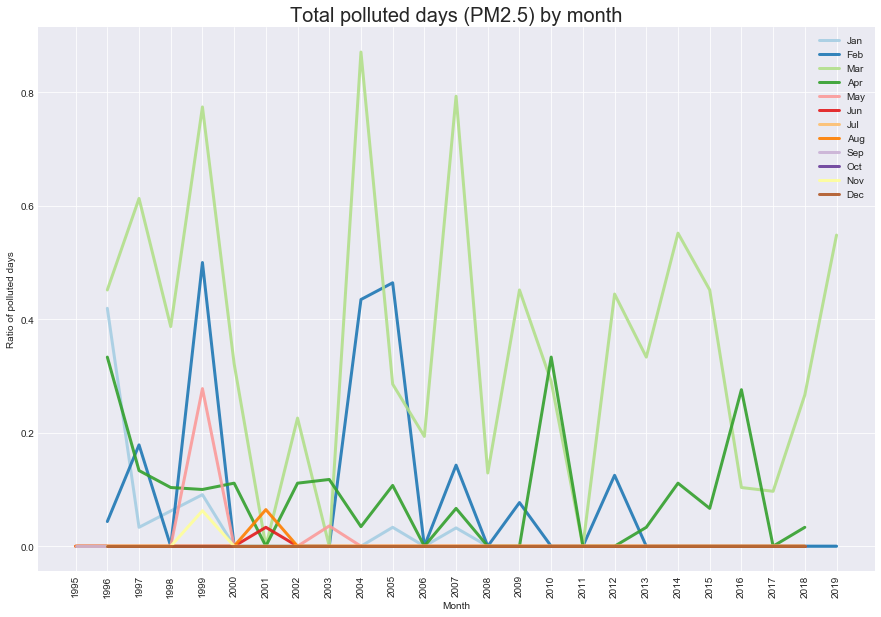

In [21]:
year_ls = list(PM_df_my['year'].unique())
year_ls.sort()

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Paired')
 
# multiple line plot
num=0

for mon in list(PM_df_my['month'].unique()):
    y = PM_df_my[PM_df_my['month'] == mon]['PM10_35T_th_R']
    x = PM_df_my[PM_df_my['month'] == mon]['year']

    plt.plot(x, y, marker='', color=palette(num), linewidth=3, alpha=0.9, label=calendar.month_abbr[mon])
    num+=1
    
# Add legend
plt.legend(loc='upper right')

plt.xticks(year_ls, year_ls,rotation=90)
plt.ylabel('Ratio of polluted days')
plt.xlabel('Month')
plt.title('Total polluted days (PM2.5) by month', loc='Center', fontsize=20, fontweight=0)


### Ratio of pollutated days in each month in different years (PM10 at Station 36T)

Text(0.5, 1.0, 'Total polluted days (PM2.5) by month')

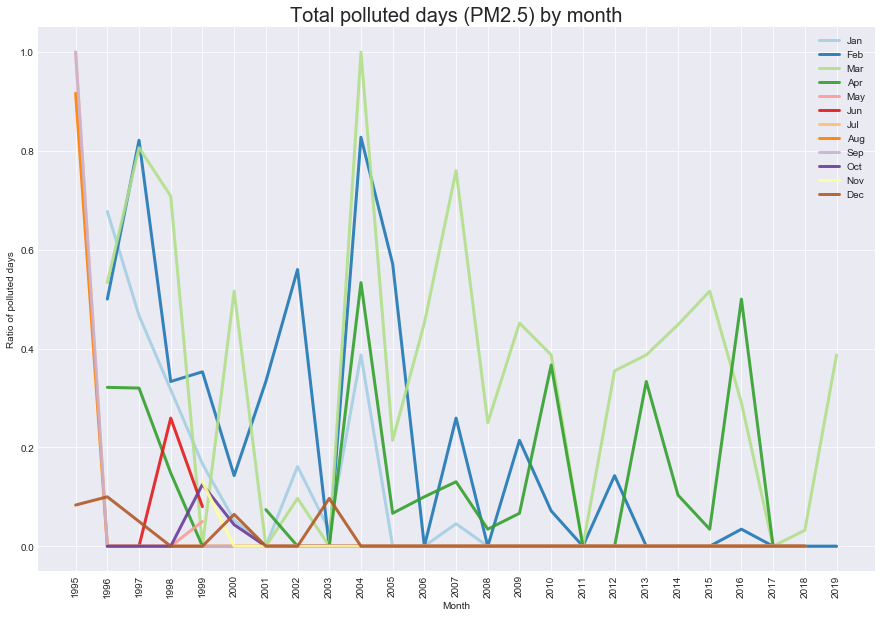

In [22]:
year_ls = list(PM_df_my['year'].unique())
year_ls.sort()

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Paired')
 
# multiple line plot
num=0

for mon in list(PM_df_my['month'].unique()):
    y = PM_df_my[PM_df_my['month'] == mon]['PM10_36T_th_R']
    x = PM_df_my[PM_df_my['month'] == mon]['year']

    plt.plot(x, y, marker='', color=palette(num), linewidth=3, alpha=0.9, label=calendar.month_abbr[mon])
    num+=1
    
# Add legend
plt.legend(loc='upper right')

plt.xticks(year_ls, year_ls,rotation=90)
plt.ylabel('Ratio of polluted days')
plt.xlabel('Month')
plt.title('Total polluted days (PM2.5) by month', loc='Center', fontsize=20, fontweight=0)
